In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
from tensorflow import keras
import shutil
import datetime
from sklearn.metrics import accuracy_score

In [2]:
import sys
import win32com.client 

In [3]:
data_dir = os.path.join('data') # whereever you extracted the data 

# the following lines are not necessary. I use them as I have a link to the dataset in a different directory 
shell = win32com.client.Dispatch("WScript.Shell")
shortcut = shell.CreateShortCut(os.path.join(data_dir, 'cartoonset100k.lnk'))
data_dir = shortcut.TargetPath

os.listdir(data_dir) 

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

In [4]:
# getting a peek into the datset
data_subdir = os.path.join(data_dir, '0')
os.listdir(data_subdir)[0:10]

['cs11502169095236683120.csv',
 'cs11502169095236683120.png',
 'cs11502298889929094331.csv',
 'cs11502298889929094331.png',
 'cs11502404786906647764.csv',
 'cs11502404786906647764.png',
 'cs11502407216397343631.csv',
 'cs11502407216397343631.png',
 'cs11502919926067511421.csv',
 'cs11502919926067511421.png']

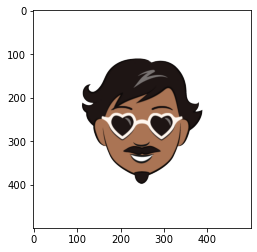

In [5]:
sample_img = os.path.join(data_subdir, 'cs11502404786906647764.png')
sample_img = plt.imread(sample_img)
plt.imshow(sample_img)

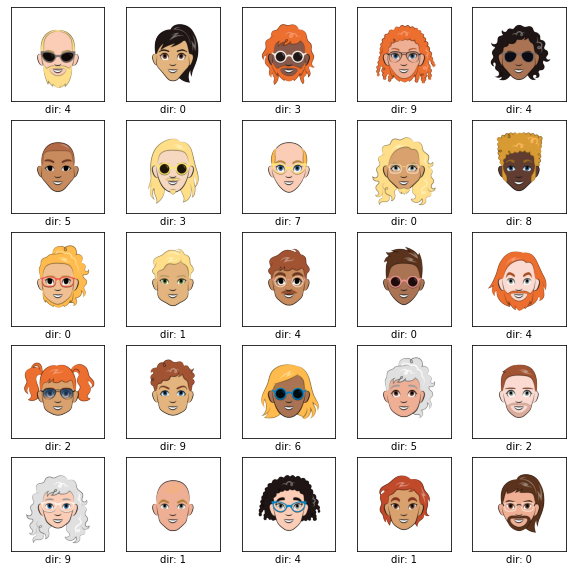

In [6]:
# plot some random selection from random sub folders in the dataset to get a feel for the data 
plt.figure(figsize=(10,10))
for i in range(25):
    subdir_name = np.random.choice(os.listdir(data_dir))
    subdir = os.path.join(data_dir, subdir_name)
    img_file = os.path.join(subdir, np.random.choice([x for x in os.listdir(subdir) if x.endswith('.png')]))
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    img = plt.imread(img_file)
    plt.imshow(img)
    plt.xlabel(f'dir: {subdir_name}')
plt.show()

In [7]:
# sample a description file. The first column is the 'feature', the second column is the value use to create 
# the artwork in [filename].png 
# the third column lists the total number of values the feature could take
# the neural network we build will discriminate between that many 'classes' 
subdir_name = np.random.choice(os.listdir(data_dir))
subdir = os.path.join(data_dir, subdir_name)
csv_file = os.path.join(subdir, np.random.choice([x for x in os.listdir(subdir) if x.endswith('.csv')]))
pd.read_csv(csv_file, header=None)

,0,1,2
0,eye_angle,0,3
1,eye_lashes,0,2
2,eye_lid,0,2
3,chin_length,0,3
4,eyebrow_weight,1,2
5,eyebrow_shape,3,14
6,eyebrow_thickness,3,4
7,face_shape,4,7
8,facial_hair,3,15
9,hair,84,111


In [8]:
# setting random seeds for reproducibility 
np.random.seed(42)
tf.random.set_seed(42)

In [9]:
cache_directory= os.path.join('C:', 'Users', 'paudy' , 'tmp_images', 'deep_learning_tmp', 'cartoonset')

In [10]:
def build_and_compile_model(num_classes=10):
    """Builds a keras sequential model with the same structure except num_classes
    args:
        num_classes: the number of notes in the final layer
    returns:
        model: a built and compiled model.
    """
    model = keras.Sequential([
    keras.layers.Conv2D(32, 3, (2, 2), activation='relu', input_shape=(256, 256, 3)), # no parameters
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.BatchNormalization(),
    ## keras.layers.Dropout(0.3), 
    keras.layers.Conv2D(64, 3, (2, 2), activation='relu'), # no parameters
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.BatchNormalization(),
    ## keras.layers.Dropout(0.3),
    keras.layers.Conv2D(128, 5, (2, 2), activation='relu'), # no parameters
    keras.layers.BatchNormalization(),
    ## keras.layers.Dropout(0.3),
    keras.layers.Conv2D(256, 5, (2, 2), activation='relu'), # no parameters
    keras.layers.BatchNormalization(),
    ## keras.layers.Dropout(0.3),
    keras.layers.Flatten(),
    keras.layers.Dense(num_classes), # no activation! 
    keras.layers.Softmax()
    ])
    model.compile(optimizer='adam',
     loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
     metrics=['accuracy'] #the metric that is reported
     )
    return model

In [11]:
# test for model build
model2 = build_and_compile_model()

In [12]:
model2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 127, 127, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 63, 63, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 31, 31, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 15, 15, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 6, 6, 128)         2

In [13]:
def copy_images_to_labels_folder(img_files, label_files, feature_name, cache_directory, label_idx_dict, reset_images=False, reuse_images=False):
    """
    copies images to the feature name subfolder in the cache directory
    images are copied into sub directories according the the lablel 
    """
    if not os.path.exists(cache_directory):
        raise Exception(f'{cache_directory} does not exist')
    feature_dir = os.path.join(cache_directory, feature_name)
    
    if os.path.exists(feature_dir):
        if reset_images:
            print(f'{feature_dir} does not exist, creating ... ')
            shutil.rmtree(feature_dir)
            os.mkdir(feature_dir)
        else:
            if reuse_images:
                #nothing to do 
                return feature_dir
            else:
                raise Exception(f'Invalid Arguments, {feature_dir} already exists, set reset_images to True to reset for {feature_name}')
    else:
        print(f'{feature_dir} does not exist, creating ... ')
        os.mkdir(feature_dir)
     
    feature_idx = label_idx_dict.get(feature_name, None)
        
    for img_file, label_file in list(zip(img_files, label_files)):
        label = pd.read_csv(label_file, header=None).loc[feature_idx][1]
        label_dir = os.path.join(feature_dir, str(label))
        if not os.path.exists(label_dir):
            print(f'{label_dir} does not exist, creating ... ')
            os.mkdir(label_dir)
        try:
            shutil.copy(img_file, label_dir)
        except:
            pass
    return feature_dir

In [14]:
def get_feature_idx_dicts(label_file):
    """
    Reads one descriptor file and constructs dictionaries to look up the features 
    args:
        label file: a sample descriptor file
    returns:
        idx_label_dict: a dictionary mapping index of descriptor to the name
        label_idx_dict: a dictionary mapping feature name to the index 
    """
    idx_label_dict = pd.read_csv(label_file, header=None)[0].to_dict()
    label_idx_dict = {v:k for k, v in idx_label_dict.items()}
    return idx_label_dict, label_idx_dict

In [15]:
# in the cached location where files are arranged in subfolders according the class read all the filenames along with path
for root, dirs, fnames_ in os.walk(data_dir):
    all_file_paths = [os.path.join(root, fname) for fname in fnames_]
img_files = [x for x in all_file_paths if x.endswith('.png')]
label_files = [x for x in all_file_paths if x.endswith('.csv')]

In [16]:
idx_label_dict, label_idx_dict = get_feature_idx_dicts(label_files[0])

In [17]:
label_idx_dict

{'eye_angle': 0,
 'eye_lashes': 1,
 'eye_lid': 2,
 'chin_length': 3,
 'eyebrow_weight': 4,
 'eyebrow_shape': 5,
 'eyebrow_thickness': 6,
 'face_shape': 7,
 'facial_hair': 8,
 'hair': 9,
 'eye_color': 10,
 'face_color': 11,
 'hair_color': 12,
 'glasses': 13,
 'glasses_color': 14,
 'eye_slant': 15,
 'eyebrow_width': 16,
 'eye_eyebrow_distance': 17}

In [ ]:
base_logdir = os.path.join('logs') # define the base logging directory where tensorboard logs are written 
base_modelsdir = os.path.join('models') # define the base model directory where all models will be saved in sub dirs 
n_epochs = 30 # we train for the same number of epochs
validation_metrics = {'accuracies': [], 'total_classes': [], 'feature_names': []} # dictionary to hold all validation metrics

for feature_name in label_idx_dict: # we will construct and evaluate models for each feature name 
    print(feature_name) 
    validation_metrics['feature_names'].append(feature_name) # index name for the validation metrics 
    
    # preprocess the files into a directory structure so that we can use keras' built-in image_dataset_from_dictionary function 
    training_dir = copy_images_to_labels_folder(img_files, label_files, feature_name, cache_directory, label_idx_dict, reuse_images=True)
    print(f'Created training dir: {training_dir}')
    total_classes = len(os.listdir(training_dir))
    validation_metrics['total_classes'].append(total_classes)
    
    # training dataset (tf.dataset), note the labels are inferred here
    train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
        training_dir,
        labels="inferred",
        label_mode="int",
        class_names=None,
        color_mode="rgb",
        batch_size=32,
        image_size=(256, 256),
        shuffle=True,
        seed=42,
        validation_split=.2,
        subset="training",
        interpolation="bilinear",
        follow_links=False,
        )
    
    # the validation directory, note the seed is set here as well for consistency and reproducibility 
    validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
        training_dir,
        labels="inferred",
        label_mode="int",
        class_names=None,
        color_mode="rgb",
        batch_size=32,
        image_size=(256, 256),
        shuffle=True,
        seed=42,
        validation_split=.2,
        subset="validation",
        interpolation="bilinear",
        follow_links=False,
    )
    
    # build and compile the model 
    model = build_and_compile_model(num_classes=total_classes)
    
    # define the logdir for this model and run 
    this_logdir = os.path.join(base_logdir, feature_name)
    if not os.path.exists(this_logdir):
        os.mkdir(this_logdir)
        
    # account for different runs by using timestamp    
    logdir = os.path.join(this_logdir, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    
    # define the tensorboard callback 
    tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

    # put model fit in a try catch to account for possible nans or corrupt data
    try:
        model.fit(train_dataset,  epochs=n_epochs, validation_data=validation_dataset, callbacks=[tensorboard_callback])
    except Exception as e:
        print(f'Error during training for {feature_name}: {e}, skipping ')
        validation_metrics['accuracies'].append(None)
        # on any exception during training simply continue to the next model 
        continue
        
    # model statistics on the validation data reprinting     
    print(model.evaluate(validation_dataset))  
    
    # define or create the model dir and create different ones for each run (for hyperparameter tuning)
    this_modeldir = os.path.join(base_modelsdir, feature_name)
    if not os.path.exists(this_modeldir):
        os.mkdir(this_modeldir)
    modelpath = os.path.join(this_modeldir, datetime.datetime.now().strftime("%Y%m%d-%H%M%S")+f'epochs-{str(n_epochs)}.h5')
    
    # save the model using Keras APIs
    model.save(modelpath, overwrite=True, include_optimizer=True)
    
    # load model for consistency and reproducibility 
    loaded_model = keras.models.load_model(modelpath)
    acc_score_sum = 0
    iterations = 0
    
    # keras sometimes gives different accuracy met
    for x, y in validation_dataset:
        acc_score_sum += accuracy_score(y, np.argmax(loaded_model.predict(x), axis=1))
        iterations+= 1
    validation_metrics['accuracies'].append(acc_score_sum/iterations)
    print(validation_metrics)

metrics_dataframe = pd.DataFrame.from_dict(validation_metrics)
metrics_dataframe.to_csv(os.path.join(base_logdir, 'metrics.csv'))

eye_angle
Created training dir: C:Users\paudy\tmp_images\deep_learning_tmp\cartoonset\eye_angle
Found 9164 files belonging to 3 classes.
Using 7332 files for training.
Found 9164 files belonging to 3 classes.
Using 1832 files for validation.
Epoch 1/30
  1/230 [..............................] - ETA: 0s - loss: 1.1021 - accuracy: 0.4062WARNING:tensorflow:From C:\Users\paudy\.conda\envs\bigyanart\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
 64/230 [=======>......................] - ETA: 18s - loss: 1.0119 - accuracy: 0.5200Error during training for eye_angle: 2 root error(s) found.
  (0) Invalid argument:  assertion failed: [Unable to decode bytes as JPEG, PNG, GIF, or BMP]
	 [[{{node decode_image/cond_jpeg/else/_1/decode_image/cond_jpeg/cond_png/else/_20/decode_image/cond_jpeg/cond_png/cond_gif/else/_